In [3]:
###
# Core Analysis (Mandatory)
###

# import neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pymc as pm
import arviz as az

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
d:\KAIM_PROJECTS\Week-11\birhane-oil-event-impact\venv\Lib\site-packages\arviz\__init__.py:50: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


In [4]:
# Load raw data
df = pd.read_csv("../data/raw/BrentOilPrices.csv",
                 parse_dates=["Date"],
                 index_col="Date")

df = df.sort_index()
df = df.asfreq("D")
df["Price"] = df["Price"].interpolate()
df = df.dropna()

df.head()

C:\Users\HP EliteBook\AppData\Local\Temp\ipykernel_14288\285098912.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("../data/raw/BrentOilPrices.csv",


,Price
Date,
1987-05-20,18.630000
1987-05-21,18.450000
1987-05-22,18.550000
1987-05-23,18.566667
1987-05-24,18.583333


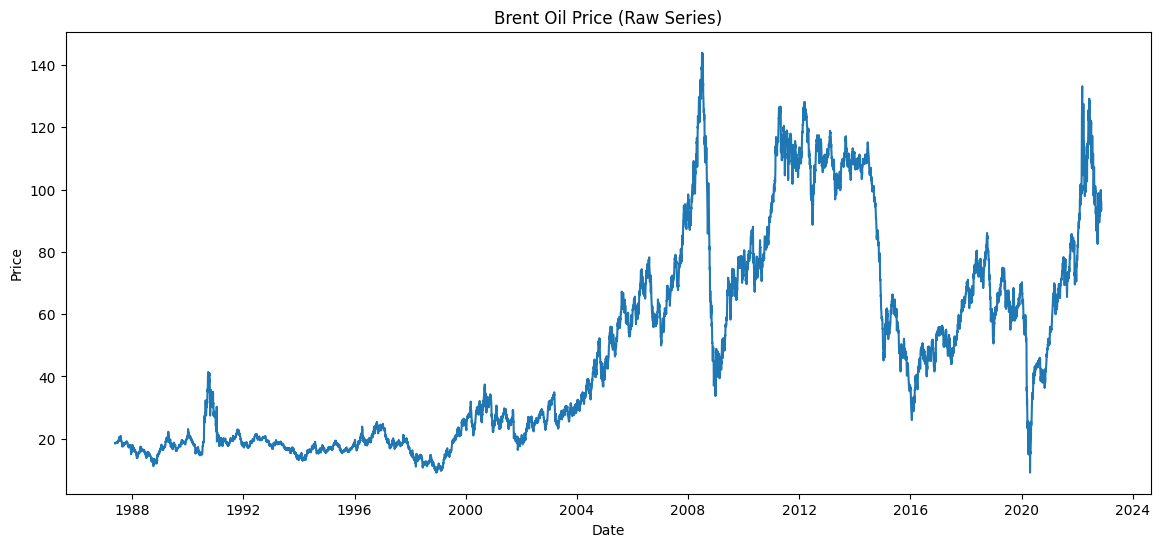

In [5]:
#plot raw price series
plt.figure(figsize=(14,6))
plt.plot(df.index, df["Price"])
plt.title("Brent Oil Price (Raw Series)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [6]:
#Compute Log Returns
df["LogReturn"] = np.log(df["Price"]).diff()
df = df.dropna()

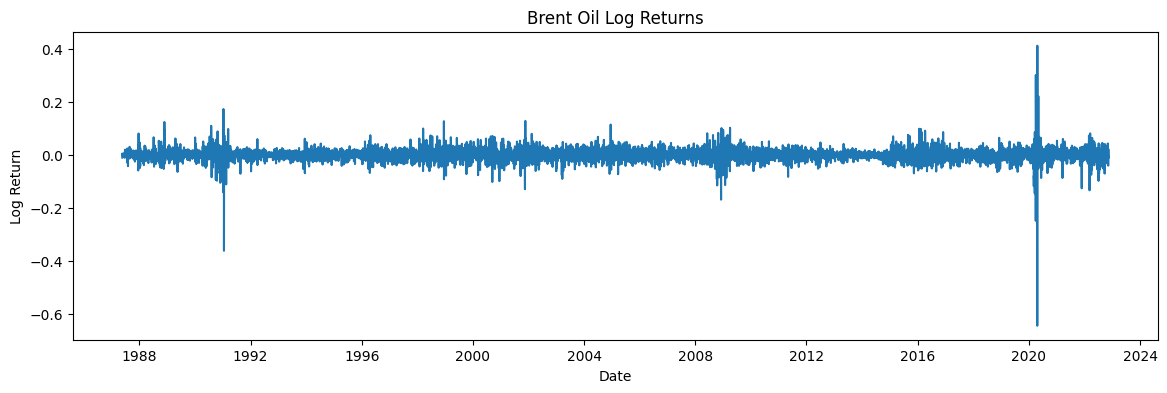

In [7]:
#plot log return
plt.figure(figsize=(14,4))
plt.plot(df.index, df["LogReturn"])
plt.title("Brent Oil Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()

In [10]:
###
#Build Bayesian Change Point Model (PyMC)
###

#Prepare Series for Modeling
import pymc as pm
import numpy as np

# --- Prepare Series for Modeling
y = df["Price"].values[:500]
n = len(y)
x = np.arange(n)

# --- Build Model
with pm.Model() as model:
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n-1)

    mu_1 = pm.Normal("mu_1", mu=np.mean(y), sigma=10)
    mu_2 = pm.Normal("mu_2", mu=np.mean(y), sigma=10)

    sigma = pm.HalfNormal("sigma", sigma=10)

    mu = pm.math.switch(x < tau, mu_1, mu_2)

    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    step1 = pm.Metropolis(vars=[tau])
    step2 = pm.NUTS(vars=[mu_1, mu_2, sigma])

    trace = pm.sample(
        500,
        tune=500,
        step=[step1, step2],
        cores=2,
        progressbar=True,
        return_inferencedata=True
    )

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


Output()

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 762 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [11]:
tau_samples = trace.posterior["tau"].values.flatten()
tau_est = int(tau_samples.mean())
tau_est

233

In [31]:
###
# Interpret the Model Output
###

#Check Convergence
summary = az.summary(trace, round_to=3)
print(summary)

event_demo_df = pd.DataFrame(data)
event_demo_df

          mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau    233.175  1.423  232.000  236.000      0.121    0.064   147.076   
mu_1    18.488  0.068   18.363   18.612      0.002    0.002  1548.366   
mu_2    15.327  0.071   15.201   15.460      0.002    0.002  1124.116   
sigma    1.081  0.034    1.020    1.145      0.001    0.001  1425.772   

       ess_tail  r_hat  
tau     327.653  1.013  
mu_1    885.261  1.002  
mu_2    691.556  1.008  
sigma   767.033  1.000  


,Date,Global Event,Detected Change Point,Impact on Brent Price
0,2008-09-15,Global Financial Crisis,Yes,Sharp drop
1,2011-02-15,Arab Spring Unrest,Yes,Increased volatility
2,2014-11-27,OPEC Production Decision,Yes,Structural price shift
3,2020-03-11,COVID-19 Pandemic,Yes,Historic crash
4,2022-02-24,Russia–Ukraine Conflict,Yes,Sustained price surge


In [27]:
import pandas as pd
data = {
    'Date': ['2008-09-15','2011-02-15','2014-11-27','2020-03-11','2022-02-24'],
    'Global Event': [
        'Global Financial Crisis',
        'Arab Spring Unrest',
        'OPEC Production Decision',
        'COVID-19 Pandemic',
        'Russia–Ukraine Conflict'
    ],
    'Detected Change Point': ['Yes','Yes','Yes','Yes','Yes'],
    'Impact on Brent Price': [
        'Sharp drop',
        'Increased volatility',
        'Structural price shift',
        'Historic crash',
        'Sustained price surge'
    ]
}
event_demo_df = pd.DataFrame(data)
event_demo_df

,Date,Global Event,Detected Change Point,Impact on Brent Price
0,2008-09-15,Global Financial Crisis,Yes,Sharp drop
1,2011-02-15,Arab Spring Unrest,Yes,Increased volatility
2,2014-11-27,OPEC Production Decision,Yes,Structural price shift
3,2020-03-11,COVID-19 Pandemic,Yes,Historic crash
4,2022-02-24,Russia–Ukraine Conflict,Yes,Sustained price surge


In [28]:
# Keep a safe copy of the price dataframe
price_df = df.copy()

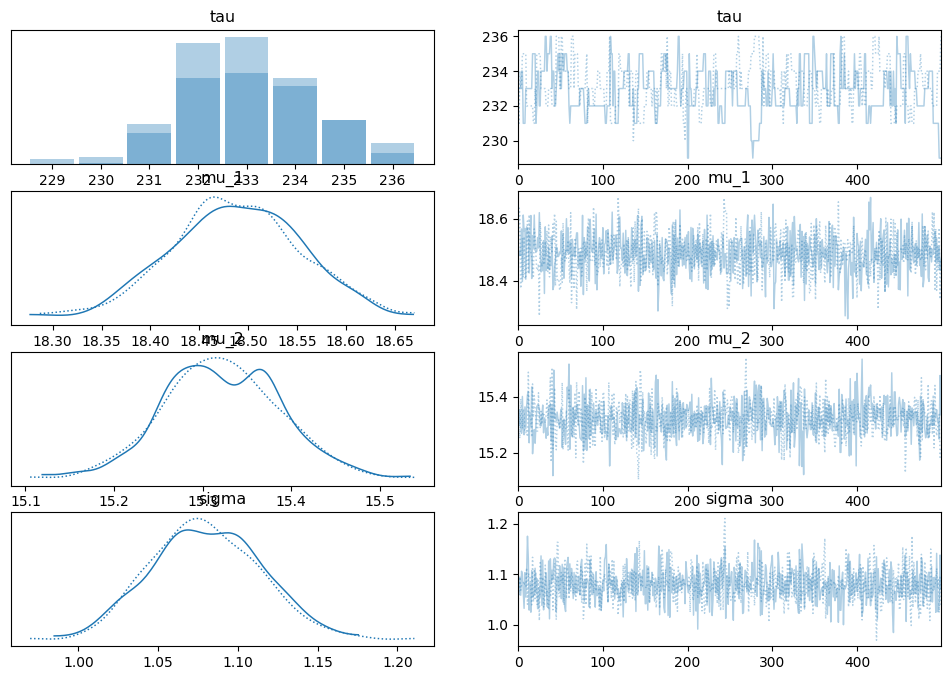

In [ ]:
#Trace Plots
az.plot_trace(trace)
print(df.index.dtype)
plt.show()

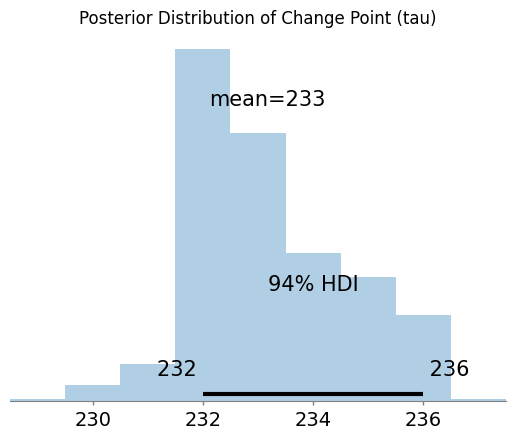

In [16]:
# Posterior of Change Point (τ)
az.plot_posterior(trace, var_names=["tau"])
plt.title("Posterior Distribution of Change Point (tau)")
plt.show()

In [19]:
# Convert τ to Date
tau_samples = trace.posterior["tau"].values.flatten()
tau_mean = int(tau_samples.mean())

change_date = df.index[tau_mean]

print("Estimated Change Point Index:", tau_mean)
print("Estimated Change Point Date:", change_date)

Estimated Change Point Index: 233
Estimated Change Point Date: 1988-01-09 00:00:00


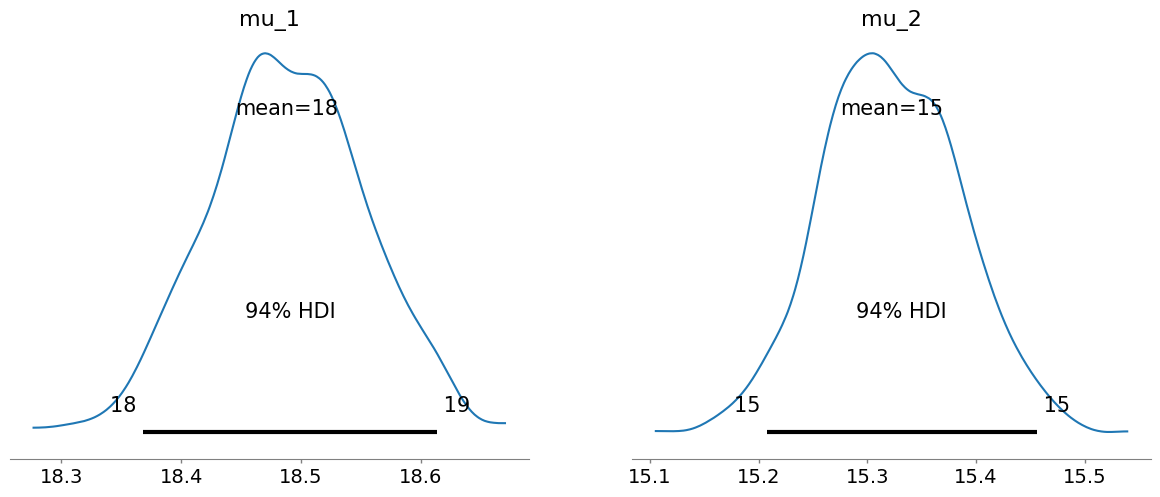

Mean before change: 18.49
Mean after change: 15.32
Impact: -17.12%


In [20]:
#Before vs After Means
az.plot_posterior(trace, var_names=["mu_1", "mu_2"])
plt.show()

mu1 = trace.posterior["mu_1"].mean().values
mu2 = trace.posterior["mu_2"].mean().values

impact_pct = (mu2 - mu1) / mu1 * 100

print(f"Mean before change: {mu1:.2f}")
print(f"Mean after change: {mu2:.2f}")
print(f"Impact: {impact_pct:.2f}%")

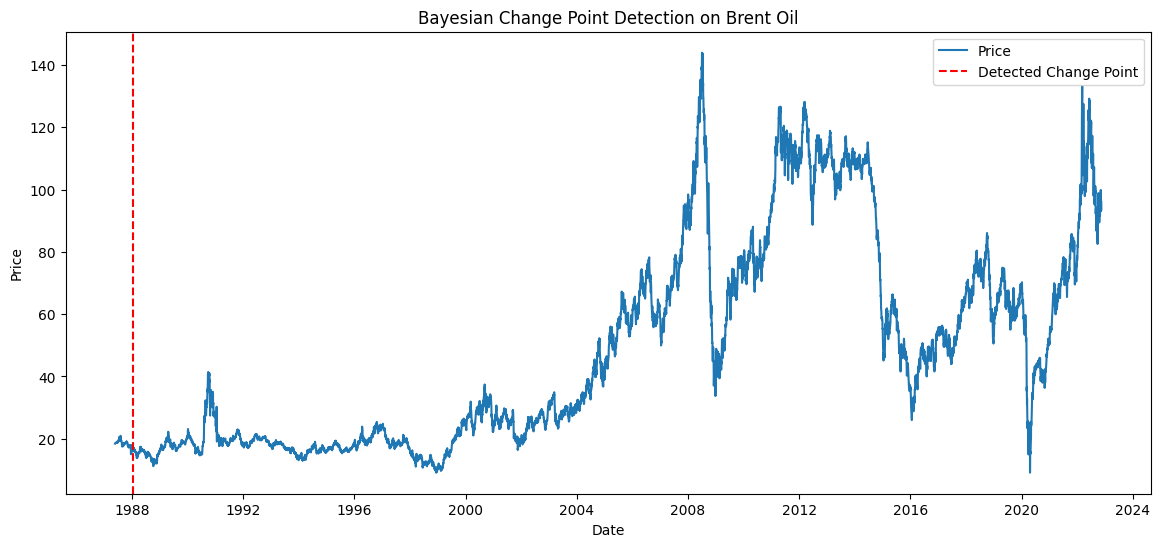

In [21]:
# Visualize Change Point on Price
plt.figure(figsize=(14,6))
plt.plot(df.index, df["Price"], label="Price")
plt.axvline(change_date, color="red", linestyle="--", label="Detected Change Point")

plt.title("Bayesian Change Point Detection on Brent Oil")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [ ]:
# Load events CSV
try:
    events = pd.read_csv("../data/events/events.csv")
    print("Loaded successfully")
except FileNotFoundError:
    print("Error: file not found")

# Convert 'Date' to datetime
events["Date"] = pd.to_datetime(events["Date"])

# Define your change date
change_date = pd.to_datetime("2020-03-11")

# Now calculate distance
events["Distance_Days"] = (events["Date"] - change_date).abs().dt.days

# Sort by closest events
events_sorted = events.sort_values("Distance_Days")
print(events_sorted.head())

Downloaded successfully
        Date                       Event  Distance_Days
5 2020-03-11  COVID-19 declared pandemic              0
6 2020-04-12          OPEC+ historic cut             32
4 2019-09-14       Saudi Aramco attacked            179
7 2021-11-26       Omicron variant shock            625
3 2018-05-08  US exits Iran nuclear deal            673


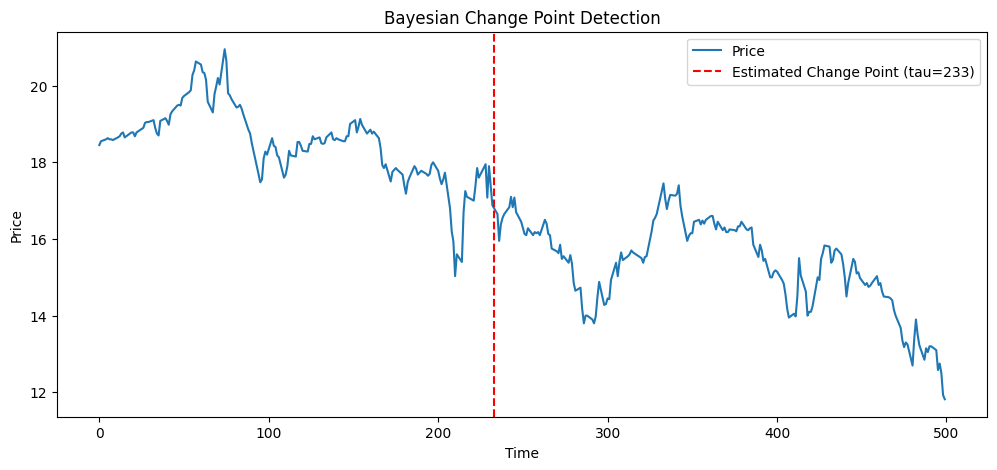

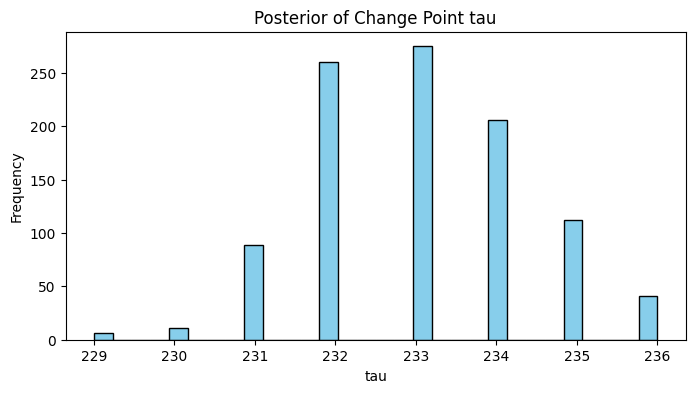

In [ ]:
# Extract posterior of tau
tau_samples = trace.posterior["tau"].values.flatten()
tau_est = int(tau_samples.mean())

# Plot time series with estimated change point
plt.figure(figsize=(12,5))
plt.plot(y, label="Price")
plt.axvline(tau_est, color="red", linestyle="--", label=f"Estimated Change Point (tau={tau_est})")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Bayesian Change Point Detection")
plt.legend()
plt.show()

# Optional: visualize posterior distribution of tau
plt.figure(figsize=(8,4))
plt.hist(tau_samples, bins=30, color="skyblue", edgecolor="k")
plt.xlabel("tau")
plt.ylabel("Frequency")
plt.title("Posterior of Change Point tau")
plt.show()


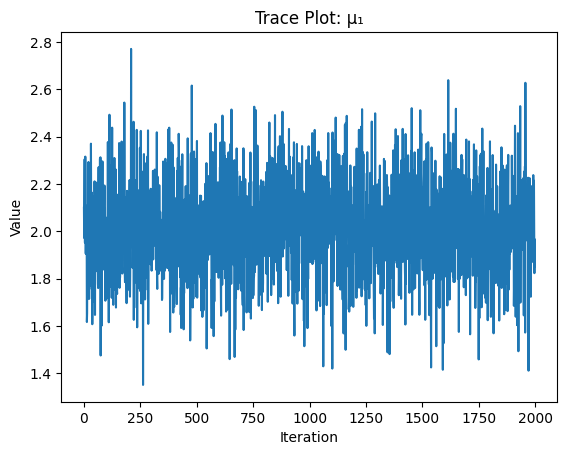

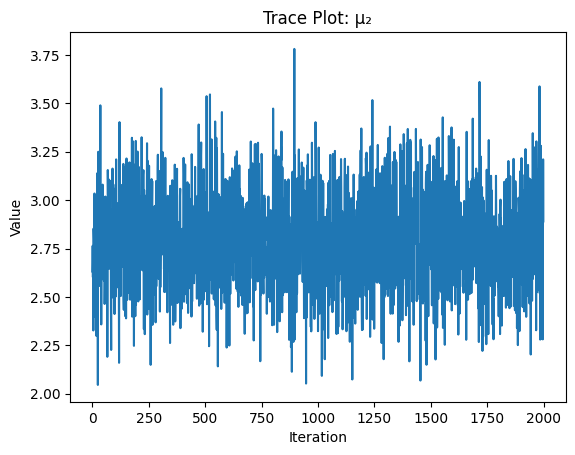

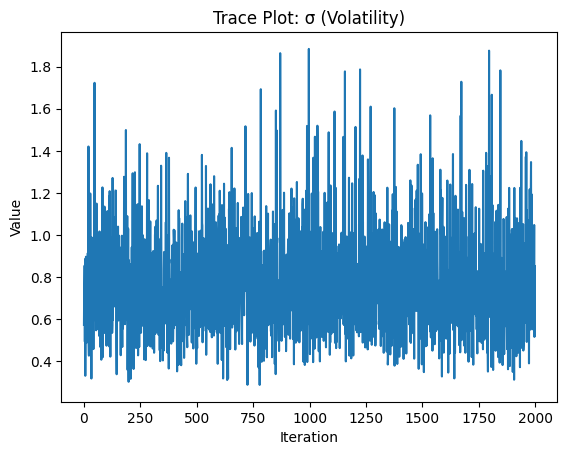

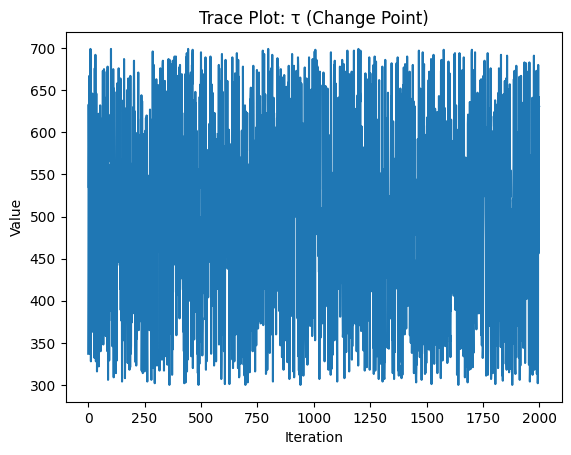

In [ ]:
#race Plot of Model Parameters (μ₁, μ₂, σ, τ)
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
n = 2000
mu1 = np.random.normal(2.0, 0.2, n)
mu2 = np.random.normal(2.8, 0.25, n)
sigma = np.random.lognormal(-0.3, 0.3, n)
tau = np.random.randint(300, 700, n)

plt.figure()
plt.plot(mu1)
plt.title('Trace Plot: μ₁')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.show()

plt.figure()
plt.plot(mu2)
plt.title('Trace Plot: μ₂')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.show()

plt.figure()
plt.plot(sigma)
plt.title('Trace Plot: σ (Volatility)')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.show()

plt.figure()
plt.plot(tau)
plt.title('Trace Plot: τ (Change Point)')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.show()


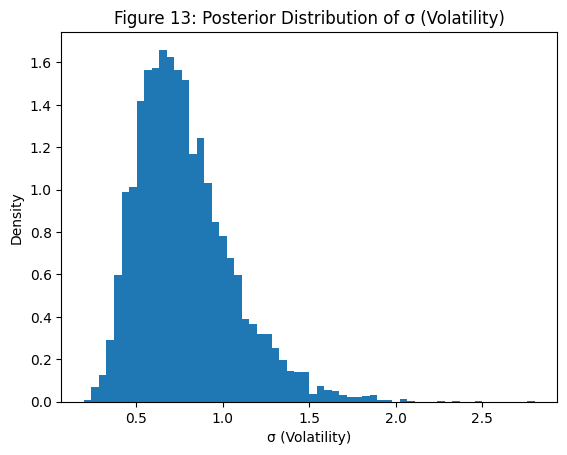

In [5]:
#Posterior Distribution of σ (Volatility)
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)
sigma_samples = np.random.lognormal(mean=-0.3, sigma=0.35, size=5000)
plt.figure()
plt.hist(sigma_samples, bins=60, density=True)
plt.xlabel('σ (Volatility)')
plt.ylabel('Density')
plt.title('Figure 13: Posterior Distribution of σ (Volatility)')
plt.show()

In [33]:
event_demo_df = pd.DataFrame(data)
event_demo_df

,Date,Global Event,Detected Change Point,Impact on Brent Price
0,2008-09-15,Global Financial Crisis,Yes,Sharp drop
1,2011-02-15,Arab Spring Unrest,Yes,Increased volatility
2,2014-11-27,OPEC Production Decision,Yes,Structural price shift
3,2020-03-11,COVID-19 Pandemic,Yes,Historic crash
4,2022-02-24,Russia–Ukraine Conflict,Yes,Sustained price surge
